In [1]:
# loading Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
# pre-processing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
# over-sampling
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
# classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
# shap importance
import shap
# progress bar
from tqdm import tqdm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


c:\Users\Admin\ML_Projects\Predict_HR_Employee_Joining_Company\Predict-HR-Employee-Joining-Company-Using-ML\myenv\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Admin\ML_Projects\Predict_HR_Employee_Joining_Company\Predict-HR-Employee-Joining-Company-Using-ML\myenv\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthed

# Feature Engineering

In [2]:
# Load The dataset:
hr_data=pd.read_csv('data.csv')
hr_data.head()

,SLNO,Candidate Ref,DOJ Extended,Duration to accept offer,Notice period,Offered band,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Joining Bonus,Candidate relocate actual,Gender,Candidate Source,Rex in Yrs,LOB,Location,Age,Status
0,1,2110407,Yes,14,30,E2,-20.79,13.16,42.86,No,No,Female,Agency,7,ERS,Noida,34,Joined
1,2,2112635,No,18,30,E2,50.00,320.00,180.00,No,No,Male,Employee Referral,8,INFRA,Chennai,34,Joined
2,3,2112838,No,3,45,E2,42.84,42.84,0.00,No,No,Male,Agency,4,INFRA,Noida,27,Joined
3,4,2115021,No,26,30,E2,42.84,42.84,0.00,No,No,Male,Employee Referral,4,INFRA,Noida,34,Joined
4,5,2115125,Yes,1,120,E2,42.59,42.59,0.00,No,Yes,Male,Employee Referral,6,INFRA,Noida,34,Joined


In [41]:
# Create a numerical and categorical features:
cat_features = [col for col in hr_data.columns if hr_data[col].dtypes == 'object']
num_features = [col for col in hr_data.columns if hr_data[col].dtypes != 'object']
print(num_features,cat_features)

['SLNO', 'Candidate Ref', 'Duration to accept offer', 'Notice period', 'Pecent hike expected in CTC', 'Percent hike offered in CTC', 'Percent difference CTC', 'Rex in Yrs', 'Age'] ['DOJ Extended', 'Offered band', 'Joining Bonus', 'Candidate relocate actual', 'Gender', 'Candidate Source', 'LOB', 'Location', 'Status']


In [3]:
# pre-processing the dataframe to build logistic regression model

n_df = hr_data.drop('Candidate Ref', axis=1)

# divide X and y(target)
X = n_df.drop('Status', axis=1)
y = n_df.Status.map({'Joined':1,
                   'Not Joined':0})

# divide the data and Over-Sample, One hot encoder and scale the data

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)

# Encoding the categorical data
cat_features = [col for col in X_trn.columns if X_trn[col].dtypes == 'object']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
OH_train = pd.DataFrame(OH_encoder.fit_transform(X_trn[cat_features]))
OH_test = pd.DataFrame(OH_encoder.fit_transform(X_tst[cat_features]))

# put the index back
OH_train.index = X_trn.index
OH_test.index = X_tst.index

# drop object cols from X_trn and X_tst
num_trn = X_trn.drop(cat_features, axis=1)
num_tst = X_tst.drop(cat_features, axis=1)

# concat onhot and num data frame
OH_X_trn = pd.concat([num_trn, OH_train], axis=1)
OH_X_tst = pd.concat([num_tst, OH_test], axis=1)

In [4]:
print("before resampling")
y_trn.value_counts()

before resampling


Status
1    5854
0    1342
Name: count, dtype: int64

In [5]:
OH_X_trn.columns = OH_X_trn.columns.astype(str)

# resample the datasets with over and under sampling
sm = SMOTEENN(enn = EditedNearestNeighbours(sampling_strategy='all', kind_sel="mode"),
             random_state=42)
X_retrn, y_retrn = sm.fit_resample(X = OH_X_trn, y= y_trn)

print("After resampling")
y_retrn.value_counts()

After resampling


Status
0    5520
1    3906
Name: count, dtype: int64

In [43]:
print(OH_X_trn,y_trn)

       SLNO  Duration to accept offer  Notice period   
7842  10203                        49             30  \
5268   6956                        14             30   
6800   8802                        66             45   
7146   9243                        47             90   
5304   7000                        62             60   
...     ...                       ...            ...   
5734   7523                        21             60   
5191   6855                         0             30   
5390   7102                        72             60   
860    1104                        27             90   
7270   9398                        31             30   

      Pecent hike expected in CTC  Percent hike offered in CTC   
7842                        41.24                        25.71  \
5268                        75.68                        62.16   
6800                        37.50                        37.50   
7146                        60.00                        24.00 

In [6]:
# Convert feature names to strings
OH_X_tst.columns = OH_X_tst.columns.astype(str)

# Resample the datasets with over and under-sampling
X_retst, y_retst = sm.fit_resample(X=OH_X_tst, y=y_tst)

print("After resampling")
y_retst.value_counts()


After resampling


Status
0    1339
1     910
Name: count, dtype: int64

In [7]:
# scale the dataset with minmax scaler
scaler = MinMaxScaler()
scaler.fit(X_retrn)
X_retrn = pd.DataFrame(scaler.fit_transform(X_retrn))
X_retst = pd.DataFrame(scaler.transform(X_retst))

# Predictive Modelling

In [8]:
# logistics regression model
LR = LogisticRegression(random_state = 42, solver='liblinear', max_iter = 1500)

# cross validation scoring
cv_score = cross_val_score(estimator=LR, X = X_retrn ,y= y_retrn, scoring='roc_auc',
                          cv=5, n_jobs=-1)

# print the mean CV score and std dev
print(np.mean(cv_score), np.std(cv_score))

0.7885991788249589 0.008879723585153362


In [9]:
# fittting the model
LR.fit(X= X_retrn, y = y_retrn) 

prediction = LR.predict(X = X_retst) # predictions on test data

print("Classification report of the logistics regression model: \n",
      classification_report(y_retst, prediction)) # print the classification report
print("======================================================")
print("Roc Auc score of the LR model: \n", roc_auc_score(y_retst, prediction)) # roc_auc
print("======================================================")
print("Accuracy score of the LR model: \n", accuracy_score(y_retst, prediction)) #accuracy

Classification report of the logistics regression model: 
               precision    recall  f1-score   support

           0       0.73      0.84      0.78      1339
           1       0.69      0.53      0.60       910

    accuracy                           0.71      2249
   macro avg       0.71      0.69      0.69      2249
weighted avg       0.71      0.71      0.71      2249

Roc Auc score of the LR model: 
 0.6854528966179452
Accuracy score of the LR model: 
 0.714539795464651


#### Observations:

**With cross-validation we found our score was much better compared to regular fitted method**

**We got 68% ROC-AUC with 71% of accuracy score with our baseline logistic regression model**

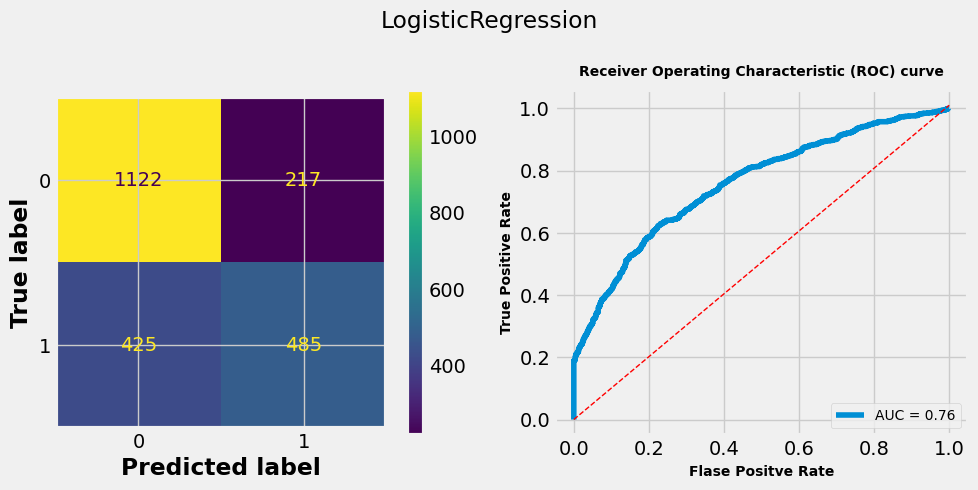

In [10]:
# confusion metrics and ROC CURVE plots
def plot_metrics(model, X:np.array, y_target:np.array) -> plt.figure:
    """
    Plot the confusion metrics and ROC-AUC curve for test dataset
    
    Arguments:
    predicted(model)
    X(array) : input test data
    y_target(array) : target_vector
    """
    prediction = model.predict(X)
    
    # compute the confusion matrix
    cm = confusion_matrix(y_target, prediction, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels = model.classes_)
    
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    fig.tight_layout(pad=3, h_pad=2, w_pad=4)
    fig.suptitle(type(model).__name__, weight=12)
    ax[0] = display.plot(ax= ax[0])
    
    # ROC CURVE
    y_pred_prob = model.predict_proba(X)[::,1]
    fpr, tpr, thresholds = roc_curve(y_target, y_pred_prob,
                                    drop_intermediate=False)
    auc = roc_auc_score(y_target, y_pred_prob)
    
    ax[1].plot(fpr, tpr,
              label= f'AUC = {auc:2.2f}')
    ax[1].plot([0,1], [0,1.01], 'r--', lw=1)
    ax[1].legend(loc='lower right', fontsize=10)
    ax[1].set_ylabel('True Positive Rate', fontsize=10)
    ax[1].set_xlabel('Flase Positve Rate', fontsize=10)
    ax[1].set_title("Receiver Operating Characteristic (ROC) curve", fontsize=10)

plot_metrics(model=LR, X=X_retst, y_target=y_retst)    

## Random Forest Classfier

In [11]:
RF = RandomForestClassifier(max_depth=10,
                           n_estimators=150,
                           max_features= 'auto') # random forest object

RF.fit(X_retrn, y_retrn) # fit the model to data


prediction1 = RF.predict(X_retst) # predict on test data

print("Classification report of the Random forest model: \n",
      classification_report(y_retst, prediction1)) # print the classification report
print("======================================================")
print("Roc Auc score of the RF model: \n", roc_auc_score(y_retst, prediction1)) # roc_auc
print("======================================================")
print("Accuracy score of the RF model: \n", accuracy_score(y_retst, prediction1)) #accuracy

Classification report of the Random forest model: 
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      1339
           1       0.82      0.89      0.85       910

    accuracy                           0.88      2249
   macro avg       0.87      0.88      0.87      2249
weighted avg       0.88      0.88      0.88      2249

Roc Auc score of the RF model: 
 0.8773124933319107
Accuracy score of the RF model: 
 0.8755002223210315


In [12]:
# Now let's do cross validation
# cross validation scoring
cv_score1 = cross_val_score(estimator=RF, X = X_retrn ,y= y_retrn, scoring='roc_auc',
                          cv=5, n_jobs=-1)

# print the mean CV score and std dev
print(np.mean(cv_score1), np.std(cv_score1))

0.9561839111693027 0.06308265695338125


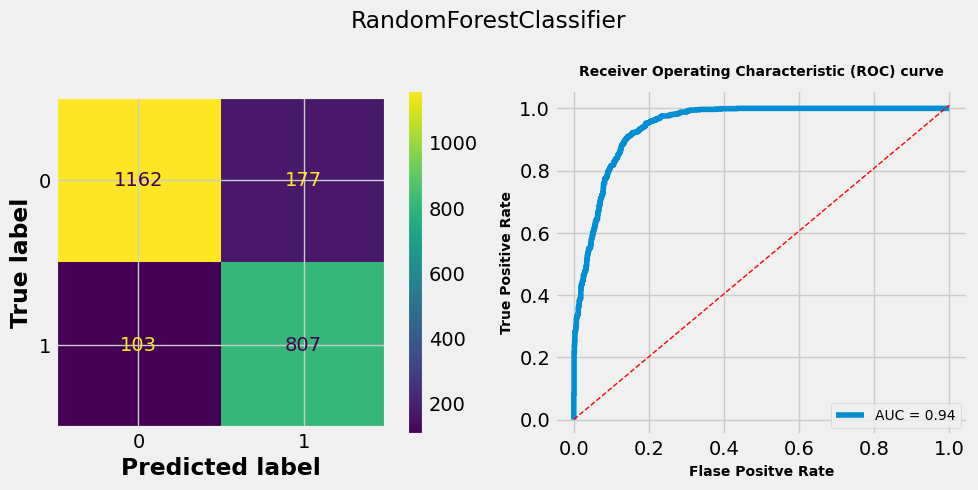

In [13]:
plot_metrics(model=RF, X=X_retst, y_target=y_retst)

#### Observations:

**As we can learn that random forest are having accuracy of 87% and AUC upto 95% with cross validation**

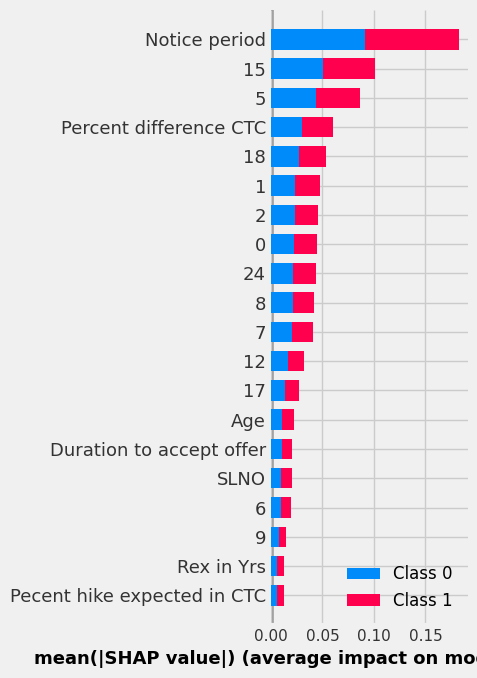

In [21]:
np.bool = np.bool_
# shap explaier of random forest model
explain = shap.TreeExplainer(RF)

shap_values = explain.shap_values(X_retst)
shap.summary_plot(shap_values, features = OH_X_trn,
                 plot_type='bar',
                 plot_size=(5,7))

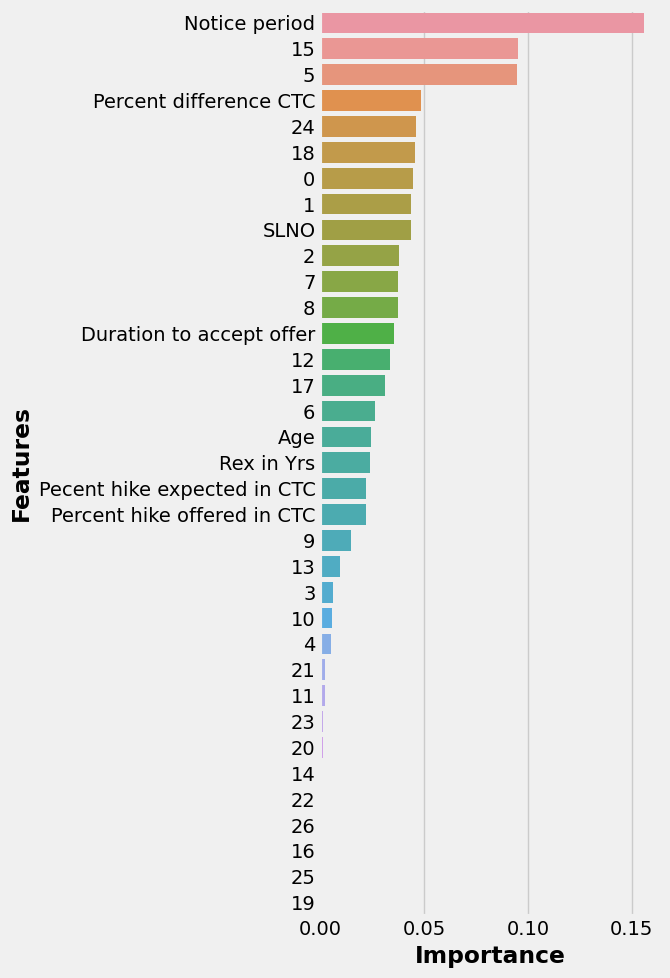

In [22]:
# using feature imporatance methods
featre_rank = pd.DataFrame({"Features": OH_X_trn.columns,
                           "Importance": RF.feature_importances_}
                          )
featre_rank2 = featre_rank.sort_values('Importance', ascending=False)

# plot the feature imp by sklearn 
plt.figure(figsize=(7,10))
sns.barplot(x='Importance',y='Features', orient='h', data=featre_rank2)
plt.show()

#### Observations

**We can learn that 'Notice period' and categorical feature of 5 and 15 are most important with both methods but their order is not the same.**

**Here, we can learn that these features are most predictor of whether or not candidate with join the company**

**Features of categories 5 and 15 are 'Joining bonus' and and 'LOB' respectivaly. so we can estimate that, both features contribute to the prediction of target variable.**

## Create Pipeline of models to find optimal classification accuracy

## Randomized SearchCV

In [23]:
# instances of each model
RF_clf = RandomForestClassifier(random_state=42)
AD_clf = AdaBoostClassifier(random_state=42)
LR_clf = LogisticRegression(random_state = 42, solver='liblinear', max_iter = 1500)
GB_clf = GradientBoostingClassifier(random_state=42)
ET_clf = ExtraTreesClassifier(random_state = 42)
DT_clf = DecisionTreeClassifier(random_state=42)
KN_clf = KNeighborsClassifier( )
SVC_clf = SVC(degree=10, probability = True, random_state = 42)
NB_clf = BernoulliNB()

In [30]:
# pipeline of all the models with gridsearchCV & RandomSearchCV

#Random Forest 1
param_RF = {}
param_RF['classifier__n_estimators'] = [50,100,150,200,250]
param_RF['classifier__max_features'] = ['auto', 'sqrt', 'log2']
param_RF['classifier__max_depth'] = [5,8,10,14,20]
param_RF['classifier__class_weight'] = [None,{0:1,1:5},
                                       {0:1,1:10},{0:1,1:15}]
param_RF['classifier'] = [RF_clf]


# Adaboost 2
param_AD = {}
param_AD['classifier__n_estimators'] = [3,4,6,8,10,15,25,40]
param_AD['classifier__learning_rate'] = [(0.96 + x/100) for x in range(0,8)]
param_AD['classifier__algorithm'] = ['SAMME','SAMME.R']
param_AD['classifier'] = [AD_clf]

# Logistic regression 3
param_LR = {}
param_LR['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param_LR['classifier__penalty'] = ['l1', 'l2']
param_LR['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param_LR['classifier'] = [LR_clf]

# Decision Tree 4
param_DT = {}
param_DT['classifier__max_depth'] = [5,10,25,None]
param_DT['classifier__min_samples_leaf'] = [2,5,10]
param_DT['classifier__criterion'] = ["gini", "entropy"]
param_DT['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param_DT['classifier'] = [DT_clf]

# Extra trees 5
param_ET = {}
param_ET['classifier__max_depth'] = [5,10,25,None]
param_ET['classifier__max_features'] = [2,5,10]
param_ET['classifier__min_samples_split'] = [2,3,10]
param_ET['classifier__min_samples_leaf'] = [1,3,10]
param_ET['classifier__bootstrap'] = [False]
param_ET['classifier__n_estimators'] = [100,300]
param_ET['classifier__criterion'] = ['gini']
param_ET['classifier'] = [ET_clf]

# K-nearest neighbors 6
param_KN = {}
param_KN['classifier__n_neighbors'] = [5,7,9,11,13,15]
param_KN['classifier'] = [KN_clf]

# Support vector classifier 7
#param_SVC = {}
#param_SVC['classifier__C'] =  [0.1, 1, 10, 100] 
#param_SVC['classifier__gamma'] = [1.0, 0.1, 0.01, 0.001]
#param_SVC['classifier__kernel'] = ['rbf', 'poly', 'sigmoid']
#param_SVC['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
#param_SVC['classifier'] = [SVC_clf]

#Naive Bayes 8 
param_NB = {}
param_NB['classifier__alpha'] = np.logspace(0,-9, num=100)
param_NB['classifier'] = [NB_clf]

# Gradient Boosting 9
param_GB = {}
param_GB['classifier__n_estimators'] = [10, 50, 100, 250]
param_GB['classifier__max_depth'] = [5, 10, 20]
param_GB['classifier'] = [GB_clf]

In [31]:
#pipeline instance
pipeline = Pipeline([('classifier', RF_clf)])

# hyperparamets list
myparams = [param_RF, param_AD, param_LR, param_DT, param_KN, param_ET, param_NB, param_GB]

In [32]:
%%time
# modelling using randomized search CV
mymodel = RandomizedSearchCV(pipeline, myparams, cv=5, n_jobs=2,
                            scoring='roc_auc').fit(X_retrn, y_retrn)

CPU times: total: 4.28 s
Wall time: 37.9 s


In [33]:
# best estimator
mymodel.best_estimator_

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 10},
                                        max_depth=20, n_estimators=200,
                                        random_state=42))])

In [34]:
mymodel.best_params_

{'classifier__n_estimators': 200,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 20,
 'classifier__class_weight': {0: 1, 1: 10},
 'classifier': RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=20,
                        n_estimators=200, random_state=42)}

In [35]:
mymodel.best_score_

0.9640804320513148

In [36]:
pred = mymodel.best_estimator_.predict(X_retst)
pred_proba = mymodel.best_estimator_.predict_proba(X_retst)
scoring = mymodel.score(X_retst, y_retst)
classif_report = classification_report(y_retst, pred)
accuracy_final = accuracy_score(y_retst, pred)
auc_score = roc_auc_score(y_retst, pred)
print("Classification report of best RF model is: \n", classif_report)
print("******************************************************")
print("Accuracy of the best RF model is: \n", round(accuracy_final,3)*100)
print("******************************************************")
print("Auc score of the best RF model is: \n", round(auc_score, 3)*100)
print("******************************************************")
print("Scoring of test data on the best estimator: \n",scoring)

Classification report of best RF model is: 
               precision    recall  f1-score   support

           0       0.94      0.84      0.89      1339
           1       0.80      0.92      0.86       910

    accuracy                           0.88      2249
   macro avg       0.87      0.88      0.87      2249
weighted avg       0.88      0.88      0.88      2249

******************************************************
Accuracy of the best RF model is: 
 87.5
******************************************************
Auc score of the best RF model is: 
 88.3
******************************************************
Scoring of test data on the best estimator: 
 0.9421021099885925


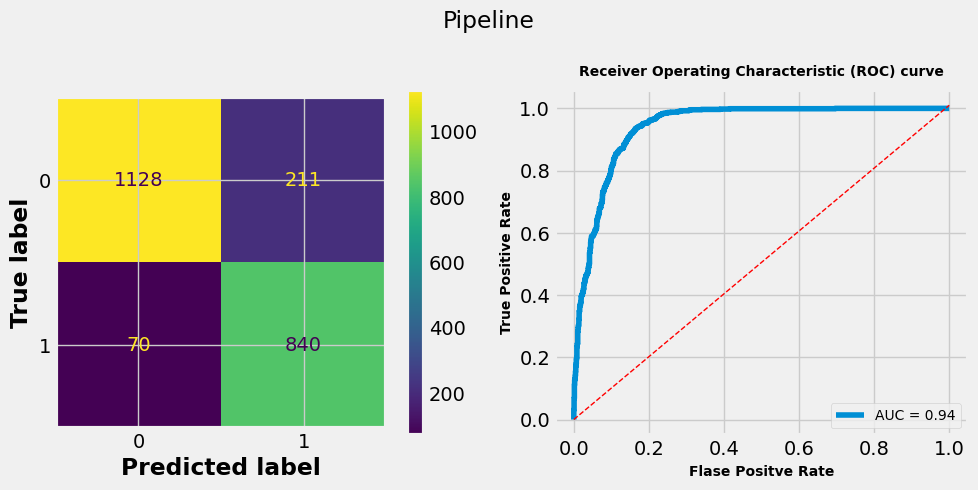

In [37]:
plot_metrics(model= mymodel.best_estimator_ , X = X_retst, y_target=y_retst)

#### Observations

**For Randomaized search CV model we found best estimator of random forest with upto accuracy of 86.6% with ROC_AUC score of 94% on test data**

**As it is randomized search of parameters with best settings accuracy and auc score vary at each notebook run**

In [38]:
# Define hyperparameters for all models

# Random Forest 
RF_params = {}
RF_params['n_estimators'] = [5,10,50,100]
RF_params['max_features'] = ['sqrt', 'log2']
RF_params['max_depth'] =  [4,5,6]
RF_params['criterion'] = ['gini', 'entropy']

# Adaboost 
AD_params = {}
AD_params['n_estimators'] =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20]
AD_params['learning_rate'] =  [(0.97 + x / 100) for x in range(0, 8)]
AD_params['algorithm'] =  ['SAMME', 'SAMME.R']

# Logistic Regression
LR_params = {}
LR_params['C'] = np.logspace(-4,4,20) 
LR_params['penalty'] = ['l1', 'l2']

# Decission Tree
DT_params = {}
DT_params['max_depth'] =  [1, 2, 3, 10, 20]
DT_params['min_samples_leaf'] = [2, 5, 10, 50, 100]
DT_params['criterion'] = ["gini", "entropy"]
# 50 combinations

# Extra Trees
ET_params = {}
ET_params['max_depth'] = [5,10,25,None]
ET_params['max_features'] = [2,5,10]
ET_params['min_samples_split'] = [2,3,10]
ET_params['min_samples_leaf'] = [1,3,10]
ET_params['bootstrap'] = [False]
ET_params['n_estimators'] = [100,300]
ET_params['criterion'] = ['gini']

# KNeighbors 
KN_params = {}
KN_params['n_neighbors'] = [5,7,9,11,13,15]
KN_params['weights'] = ['uniform','distance']
KN_params['metric' ] = ['minkowski','euclidean','manhattan']

# Support Vector Classifier
#SVC_params = {}
#SVC_params['C'] = [0.1,1, 10, 100]
#SVC_params['gamma'] = [1,0.1,0.01,0.001]
#SVC_params['kernel'] = ['rbf', 'poly', 'sigmoid']

# Naive Bayes
NB_params = {}
NB_params['alpha'] = [0.01, 0.1, 0.5, 1.0, 10.0]

# Gradient Boosting
GB_params = {}
GB_params['n_estimators'] = [10, 50, 100, 250]
GB_params['max_depth'] = [5, 10, 20]

In [39]:
# model list and parameters list
model_list = [RF_clf, AD_clf, ET_clf, LR_clf, DT_clf, KN_clf, NB_clf, GB_clf]
param_list = [RF_params, AD_params, ET_params, LR_params, DT_params, KN_params, NB_params, GB_params]

# zip the model and param list dict of dicts 
init_models = dict(zip(model_list,param_list))

In [40]:
%%time
# Grid search CV models

for model, params in tqdm(init_models.items()):
    
    mymodel = GridSearchCV(estimator=model,
                          param_grid=params,
                          scoring='roc_auc',
                          cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                          n_jobs=-1)
    mymodel.fit(X_retrn, y_retrn)
    best_model = mymodel.best_estimator_
    best_params = mymodel.best_params_
    best_score = mymodel.best_score_
    preds = mymodel.predict(X_retst)
    accuracyGSCV = accuracy_score(y_retst, preds)
    roc_auc = roc_auc_score(y_retst, preds)
    classif_report = classification_report(y_retst, preds)
    
print(f"Classification report of best {best_model} is: \n", classif_report)
print("******************************************************")
print(f"Accuracy of the best {best_model} is: \n", round(accuracyGSCV,3)*100)
print("******************************************************")
print(f"Auc score of the best {best_model} is: \n", round(roc_auc, 3)*100)
print("******************************************************")
print("Scoring of the best estimator: \n", best_score)
print("******************************************************")
print(f"Best model is {best_model} and best parameters are \n{best_params}")

100%|██████████| 8/8 [25:58<00:00, 194.85s/it]


Classification report of best GradientBoostingClassifier(max_depth=10, n_estimators=250, random_state=42) is: 
               precision    recall  f1-score   support

           0       0.93      0.85      0.89      1339
           1       0.81      0.91      0.85       910

    accuracy                           0.87      2249
   macro avg       0.87      0.88      0.87      2249
weighted avg       0.88      0.87      0.88      2249

******************************************************
Accuracy of the best GradientBoostingClassifier(max_depth=10, n_estimators=250, random_state=42) is: 
 87.4
******************************************************
Auc score of the best GradientBoostingClassifier(max_depth=10, n_estimators=250, random_state=42) is: 
 87.9
******************************************************
Scoring of the best estimator: 
 0.9677216820580185
******************************************************
Best model is GradientBoostingClassifier(max_depth=10, n_estimators=250,

#### Observations

**We recieved best scoring on training dataset as it overfits the data but our testing accuracy is low with gradient boosting classifer.**

**With Gradient boosting being the best model, model accuracy on testing data is about 87.4% and ROC-AUC score is about 87.9%**

 Summary of model performances:

|       Model name    | ROC-AUC | Accuracy |
|---------------------|---------|----------|
|Logistics            |   68%   |   71%    |
|RFC                  |   86%   |   86%    |
|RFC(RandomizedSearch)|upto94%  |   86.7%  |
|GBT(Gridsearch)      |   87.4% |   87.9.7%  |

# Conclusions

**In the end, as per the project objective, we needed to answer HR that what affects candidates joining in the company?, here are our answers🔽**

1. Notice period affects the most whether or not candidate will join the company.
2. If offered hike is lower than expected than candidate is more likely to withdraw from the application
3. LOB and joning bonus affect the likelihood of the candidates.
